### Implementation for FGSM attack on a CNN classifier of MNIST dataset. 

In [1]:
import torch
from utils import data_loader
from mnist_classifier import NeuralModel
import mnist_classifier
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pickle
from vae_models import VAE_CONV_NeuralModel
from utils.viewer import show_batch
import time 

In [2]:
train_set, test_set = data_loader.get_data()

batch_size = 1

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

epsilons = [0, .05, .1, .15, .2, .25, .3]
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

classification_model = NeuralModel()
classification_model.load_state_dict(torch.load("models/trained_model"))


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [3]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [4]:
def test(model, device, test_loader, epsilon):
    # Accuracy counter
    correct = 0
    adv_examples = []
    
    model.eval()
    model.to(device)
    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
        
        # Save the adv examples for visualization later
        
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))

    # Calculate final accuracy for this epsilon
    final_acc = correct / float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [5]:
accuracies = []
examples = []

In [6]:
#Run test for each epsilon
time_1 = time.time()
for eps in epsilons:
    print("=*="*20)
    acc, ex = test(classification_model, device, test_loader, eps)
    accuracies.append(acc)

    with open('models/adversarial_examples/adversarial_examples_epsilon='+str(eps)+'_.pkl', 'wb') as f:
        pickle.dump(ex, f)

=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Epsilon: 0	Test Accuracy = 9883 / 10000 = 0.9883
=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Epsilon: 0.05	Test Accuracy = 8086 / 10000 = 0.8086
=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Epsilon: 0.1	Test Accuracy = 4243 / 10000 = 0.4243
=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Epsilon: 0.15	Test Accuracy = 2120 / 10000 = 0.212
=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Epsilon: 0.2	Test Accuracy = 1176 / 10000 = 0.1176
=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Epsilon: 0.25	Test Accuracy = 821 / 10000 = 0.0821
=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Epsilon: 0.3	Test Accuracy = 711 / 10000 = 0.0711


the time needed to perform the attacks is:  1040.4080200195312  seconds
[0.9883, 0.8086, 0.4243, 0.212, 0.1176, 0.0821, 0.0711]


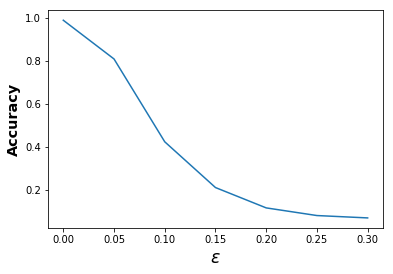

In [31]:
time_2 = time.time()

print("the time needed to perform the attacks is: ", time_2-time_1, " seconds")

print(accuracies)
plt.plot(epsilons, accuracies)
plt.xlabel('$\epsilon$', size = 'xx-large', fontweight = 'demi')
plt.ylabel('Accuracy', size = 'x-large', fontweight = 'demi')
plt.show()